# Figure 3: Plotting the NR data

These routines take the output from the Refl1D fits and plots:

* The measured NR data from all three measurements

* The simulated NR data for all three fits, including best fits and confidence intervals (68% and 95%)

* The SLD profiles for the 68% and 95% confidence intervals (CIs). The CIs are sufficiently narrow that plotting the best fit obscures them entirely.  As such, the CIs are a sufficient representation of the best fit, and the best fits are not explicitly plotted.

## Import the necessary modules

In [1]:
#Header - import statemetns
from sys import argv
from os import listdir, path, chdir, getcwd, remove
from os import name as osname

from os.path import join, exists
from re import split
from numpy import log
from datetime import datetime


#from subprocess import call
import numpy as np
from numpy import genfromtxt, log10,hstack,vstack,linspace,interp
from numpy import min as nmin
from numpy import max as nmax
from matplotlib import pyplot as plt
from matplotlib import rcParams
from bumps.cli import recall_best,load_model,install_plugin
from bumps.dream.state import load_state
from bumps.plotutil import form_quantiles


from refl1d import fitplugin
from refl1d.errors import align_profiles
from refl1d.errors import calc_errors


## Identify the folders where the fit data reside, and provide legend entries:

In [2]:
models = {'1':'w3_SimFit_eps_p40_3kB_3kS_06042018','3':'w4_2layerFixElyte_thicker_eps_3kB_3kS_04182018'}
legends = {'1': 'W'+r'$_{\mathrm{bare}}$','2': 'W'+r"$_{\mathrm{SEI}}$",'3':'W'+r'$_{\mathrm{elyte}}$'}

## Define the function to re-load the data

In [3]:
def reload_reflectivity(problem, state, nshown=50, random=False):
       
    points, logp = state.sample()
    if points.shape[0] < nshown: nshown = points.shape[0]
    # randomize the draw; skip the last point since state.keep_best() put
    # the best point at the end.
    if random: points = points[np.random.permutation(len(points)-1)]
    points = points[-nshown:-1]

    # Define the model/s (for either a single or multi-fit problem)
    if hasattr(problem, 'models'):
        models = [m.fitness for m in problem.models]
    else:
        models = [problem.fitness]

    # Initialize a list of the experiments:
    experiments = []
    
    # Load the experiments to this list:
    for m in models:
        if hasattr(m,'parts'):
            experiments.extend(m.parts)
        else:
            experiments.append(m)
    
    # Initialize Python dictionaries for:
    # ...the scattering vector array,
    Q = dict((m,[]) for m in experiments)  
    # ...the measured reflectivity at each Q,
    ReflData = dict((m,[]) for m in experiments)   
    # ...the simulated reflectivity at each Q,
    ReflSim = dict((m,[]) for m in experiments)
    # ...the residual/uncertainty at each Q,
    Qres = dict((m,[]) for m in experiments)
    # ...the measured reflectivity residual/uncertainty at each Q,
    Rres = dict((m,[]) for m in experiments)
    # ...the posterior population of SLD profiles,
    profiles = dict((m,[]) for m in experiments)
    # ...the residual between the modeled and measured reflectivity,
    residuals = dict((m,[]) for m in experiments)
    # ...the 'slab' data (layer thicknesses) for each model,
    slabs = dict((m,[]) for m in experiments)
    # ...and the layer interface widths for each model:
    ints = dict((m,[]) for m in experiments)
    
    # Load the experimental data to the relevant dictionaries:
    for m in experiments:
        refl = m.reflectivity()
        Q[m].append(m.probe.Q)
        ReflData[m].append(m.probe.R)
        Qres[m].append(m.probe.dQ)
        Rres[m].append(m.probe.dR)
                
    
    # Load the fiting data to the relevant dictionaries:
    def record_point():
        for m in experiments:
            D1 = m.reflectivity()
            D2 = m.residuals()
            ReflSim[m].append(D1[1]+0)
            residuals[m].append(D2+0)
            slabs_i = [L.thickness.value for L in m.sample[1:-1]]
            slabs[m].append(np.array(slabs_i))
            ints_i = [L.interface.value for L in m.sample[0:-1]]
            ints[m].append(np.array(ints_i))
            # Read out the SLD profile:
            z,rho,irho = m.smooth_profile()
            profiles[m].append((z+0,rho+0,irho+0))
            zStep, rhoStep, irhoStep = m.step_profile()
            
    # Having defined how to add the data, we now loop through all the models and add 
    #    their data to the dictionaries, starting with the best fit:
    record_point()
    # Now loop over the other fits:
    for p in points:
        problem.setp(p)
        record_point()

    # Turn data into arrays
    Q = dict((k,np.asarray(v).T) for k,v in Q.items())
    Qres = dict((k,np.asarray(v).T) for k,v in Qres.items())
    Rres = dict((k,np.asarray(v).T) for k,v in Rres.items())
    ReflSim = dict((k,np.asarray(v).T) for k,v in ReflSim.items())
    ReflData = dict((k,np.asarray(v).T) for k,v in ReflData.items())    
    residuals = dict((k,np.asarray(v).T) for k,v in residuals.items())

    # Return the data:
    return profiles, slabs, Q, Qres, ReflSim, ReflData, Rres


## Define some other helper functions:

In [4]:
# Helper Functions
def checkfiles(dirname):
    """
    #LOOK FOR ROOT NAME OF FIT
    """
    nmes = listdir(dirname)
    for line in nmes:
        if ("-chain.mc" in line) and (not "-chain.mc.xz" in line):
            mname = line[:-9]
    return mname

def xz(dirname):
    """
    #EXTRACT compressed files
    """
    nmes = listdir(dirname)
    cdir = getcwd()
    chdir(dirname)
    for i in nmes:
        if "mc.xz" in i:
            print('found ' + i)
            if not path.exists(i[:-3]) and path.exists(i):
                print('extracting ' + i)
                if osname == 'nt':
                    from subprocess import call
                    call("C:\\Program Files\\7-Zip\\7z.exe e " + i)
                elif osname == 'posix':
                    from subprocess import Popen
                    Popen(["/usr/bin/xz","-d","-v","--keep","--threads=8",i])
                print('\n')
    chdir(cdir)

def xzd(dirname):
    """
    #DELETE extracted files after use
    """
    nmes = listdir(dirname)
    cdir = getcwd()
    chdir(dirname)
    for i in nmes:
        if "mc.xz" in i:
            if path.exists(i[:-3]) and path.exists(i):
                print("deleting " + i[:-3])
                remove(i[:-3])
    chdir(cdir)

def _align_profiles(profiles, slabs, align):
    """  Align profiles for each sample
       
    For multiple experiments, first align the best fits from each: """
    p1s = [ ]
    s1s = [ ]
    keys = [ ]
    for m in profiles.keys():
        pS = profiles[m]
        ss = slabs[m]
        p1s.append(pS[0])
        s1s.append(ss[0])
        keys.append(m)

    for m in profiles.keys():
        profiles[m].insert(0,p1s[0])
        slabs[m].insert(0,s1s[0])

    pS_aligned = _align_profile_set(p1s,s1s,align)


    for i in range(len(keys)):
        profiles[keys[i]][0] = pS_aligned[i][:]


    return dict((m,_align_profile_set(profiles[m], slabs[m], align))
                for m in profiles.keys())

def _align_profile_set(profiles, slabs, align):
    """ Align all profiles to the first profile. """
    p1 = profiles[0]
    t1_offset = _find_offset(slabs[0], align) if align != 'auto' else None
    #print t1_offset
    offsets = [0]
    for p2,t2 in zip(profiles[1:], slabs[1:]):
        offsets.append(_align_profile_pair(p1[0],p1[1],t1_offset,
                                           p2[0],p2[1],t2,
                                           align))

    profiles = [tuple([p[0]+offset]+list(p[1:]))
                for offset,p in zip(offsets,profiles)]
    return profiles

def _align_profile_pair(z1,r1,t1_offset,z2,r2,t2,align):
    """ Use autocorrelation to align a single pair of profiles (r1 and r2)."""
    if align == 'auto':
        # Assume z1,z2 have the same step size
        n1,n2 = len(r1),len(r2)
        idx = np.argmax(np.correlate(r1,r2,'full'))
        if idx < n2:
            offset = z2[n2-idx-1] - z1[0]
        else:
            offset = z2[0] - z1[idx-n2+1]
        return -offset
    else:
        return -(_find_offset(t2, align) - t1_offset)

def _find_offset(v, align):
    """
        Find the offset of k.p, where k is the interface number and p is the
        distance into that interface.

        This may even work for interfaces defined from the left, such as
        -1.5 to specify the middle of the final layer.
        """
    idx = int(align)
    offset = np.sum(v[:idx]) + (align-idx)*v[idx]
    #print offset, idx, v[:idx], align
    return offset


def loadfit(dirname):
    """
    #decompress mc.xz files, load best fit, state
    """
    xz(dirname)
    mname = checkfiles(dirname)

    store = path.join(dirname,mname)
    problem = load_model(store+".py")

    recall_best(problem,store+".par")
    csq = problem.chisq()
    print("chisq = " + str(csq))

    if hasattr(problem, 'models'):
        models = [m.fitness for m in problem.models]
    else:
        models = [problem.fitness]

    experiments = []

    for m in models:
        if hasattr(m,'parts'):
            experiments.extend(m.parts)
        else:
            experiments.append(m)

    z = dict((m,[]) for m in experiments)
    rho = dict((m,[]) for m in experiments)
    irho = dict((m,[]) for m in experiments)
    profiles = dict((m,[]) for m in experiments)
    slabs = dict((m,[]) for m in experiments)
    Q = dict((m,[]) for m in experiments)
    residuals = dict((m,[]) for m in experiments)
    csq = dict((m,[]) for m in experiments)

    state = load_state(store)
    xzd(dirname)

    profiles, slabs, Q, Qres, ReflSim, ReflData, Rres = reload_reflectivity(problem, state, nshown = 50, random = False)
    
    for m in experiments:
        z[m],rho[m],irho[m] = m.smooth_profile(dz=0.2)

    profiles = _align_profiles(profiles,slabs,-1.0)#'auto'

    return store, models, z, rho, irho, profiles, slabs, Q, Qres, ReflSim, ReflData, Rres, csq

def makequantiles(profiles,contours,npoints):
    """
    #LIFTED FROM refl1d.errors: calculate the quantiles specified by `contours`
    """
    zp = dict((m,[]) for m,p in profiles.items())
    pp = dict((m,[]) for m,p in profiles.items())
    qp = dict((m,[]) for m,p in profiles.items())

    for m,p in profiles.items():
        # Find limits of all profiles
        z = hstack([line[0] for line in p])
        zp[m] = linspace(nmin(z), nmax(z), npoints)
        # Interpolate rho on common z
        rho = vstack([interp(zp[m], L[0], L[1]) for L in p])
        pp[m], qp[m] = form_quantiles(rho, contours)

    return pp, qp, zp

# Set up the Plot

In [5]:
# Define the color palette:
cmap = plt.get_cmap('plasma')
ndata = 10
color_ind = np.linspace(0,1,ndata)
colors = list()

for i in np.arange(ndata):
    colors.append(cmap(color_ind[i]))

colors = [colors[6], colors[0], colors[5]]
ce = 'k'

# Set the default font:
fontname = 'Times New Roman'

# Define the confidence intervals to show
contours = [68,95]
# Set the number of points used in z profile
npoints = 200

# Load the models

In [7]:
# Initialize the dictionaries to hold the data:
store = dict((m,[]) for m in models) 
modelArray = dict((m,[]) for m in models) 
z = dict((m,[]) for m in models) 
rho = dict((m,[]) for m in models) 
irho = dict((m,[]) for m in models) 
profiles = dict((m,[]) for m in models) 
slabs = dict((m,[]) for m in models) 
Q = dict((m,[]) for m in models) 
Qres = dict((m,[]) for m in models) 
ReflSim = dict((m,[]) for m in models) 
ReflData = dict((m,[]) for m in models) 
Rres = dict((m,[]) for m in models) 
csq = dict((m,[]) for m in models) 
p = dict((m,[]) for m in models) 
q = dict((m,[]) for m in models) 
zp = dict((m,[]) for m in models) 


for m in models:
    ind = int(m)
    print(ind)
    
    store[m], modelArray[m], z[m], rho[m], irho[m], profiles[m], slabs[m], Q[m], Qres[m], ReflSim[m], ReflData[m], Rres[m], csq[m] = loadfit(models[m])
    p[m],q[m],zp[m] = makequantiles(profiles[m],contours,npoints)
#store, models, z, rho, irho, profiles, slabs, Q, Qres, ReflSim, ReflData, Rres, csq = loadfit(fit1)
#store[2][:], models[2][:], z[2][:], rho[2][:], irho[2][:], profiles[2][:], slabs[2][:], Q[2][:], Qres[2][:], 
#ReflSim[2][:], ReflData[2][:], Rres[2][:], csq[2][:] = loadfit(fit1)


#p,q,zp = makequantiles(profiles, contours, npoints)

1
chisq = 1.8422600541064247
3
chisq = 2.28080073478471


## FIgure 3b: set up the figure and plot the SLD profiles

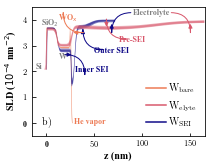

In [8]:
fig = plt.figure()
# set the dimensions and positions of the panels: left,bottom,width,height
fig.set_size_inches([3.0,2.25])
ax = {"zpro": fig.add_axes([0.15,0.15,0.8,0.8])}#axis for z SLD profiles

# Initialize the number of profiles plotted:
iplot = 0

# Initialize the offsets for all three profiles:
offset = [0., 0., 0.]


# Disclaimer: these offsets are determined by trial and error.  I'm sure there is a more efficient way to do this:
for m in modelArray:
    for n in modelArray[m]:
        if iplot==1:
            offset[iplot] = zp[m][n][-1]*0.1 -0.8
            iplot+=1
        elif iplot==2:
            offset[iplot] = zp[m][n][-1]*0.1-2.0
            iplot+=1
        else:
            offset[iplot] = zp[m][n][0]*0.1+1.325
            iplot+=1

# Reset iplot to zero:
iplot=0
# For the w4elt plot, drop the final 40 points of electrolyte SLD (it is all the same SLD, but just stretches past
#    the point where the profile is necessary):
start=40

# Loop through the models and plot:
for m in models:
    for n in modelArray[m]:
        # Set the color:
        c = colors[iplot]
    
        if iplot==1: # w3ocv data:
            for lo, hi in q[m][n]:##LIFTED FROM bumps.plotutil - plot the confidence bounds on the SLD profile
                ax['zpro'].fill_between(-zp[m][n]*0.1+offset[iplot], lo, hi,facecolor=c, edgecolor='None',alpha=0.5)#, hold=True)
        elif iplot==2: # w4elt data
            for lo, hi in q[m][n]:##LIFTED FROM bumps.plotutil - plot the confidence bounds on the SLD profile
                ax['zpro'].fill_between(-zp[m][n][start:]*0.1+offset[iplot], lo[start:], hi[start:],facecolor=c, edgecolor='None',alpha=0.5)
        else: # w3bare data:
            for lo, hi in q[m][n]:##LIFTED FROM bumps.plotutil - plot the confidence bounds on the SLD profile
                ax['zpro'].fill_between(zp[m][n]*0.1+offset[iplot], lo, hi,facecolor=c, edgecolor='None',alpha=0.5)#, hold=True)

        # Increment iplot:
        iplot += 1


# Label the SLDs
#     Layers specific to one model are given that model's color.
#     Layers common to both models are colored grey.
plt.rcdefaults()
ax['zpro'].text(90.,4.2,"Electrolyte",fontsize=8,family='Times New Roman',color='0.5')
ax['zpro'].annotate("",xy=(150,3.915),xytext=(128.,4.269),arrowprops=dict(arrowstyle="-|>",facecolor=colors[2],
                    edgecolor=colors[2], connectionstyle="angle,angleA=180,angleB=-90,rad=20"),fontsize=8,)
ax['zpro'].annotate("",xy=(68,3.915),xytext=(90.,4.269),arrowprops=dict(arrowstyle="-|>",facecolor=colors[1],
                    edgecolor=colors[1],connectionstyle="angle,angleA=180,angleB=-90,rad=20"),fontsize=8,)
ax['zpro'].text(75.5,3.15,'Pre-SEI',fontsize=8,family='Times New Roman',color=colors[2])
ax['zpro'].annotate("",xy=(62.5,3.65),xytext=(75.5,3.25),arrowprops=dict(arrowstyle="-|>",facecolor=colors[2],
                    edgecolor=colors[2],connectionstyle="angle,angleA=180,angleB=90,rad=20"),fontsize=8,)
ax['zpro'].text(50.,2.75,'Outer SEI',fontsize=8,family='Times New Roman',color=colors[1])
ax['zpro'].annotate("",xy=(38.,3.7),xytext=(50.,2.85),arrowprops=dict(arrowstyle="-|>",facecolor=colors[1],
                    edgecolor=colors[1],connectionstyle="angle,angleA=180,angleB=90,rad=20"),fontsize=8,)
ax['zpro'].text(30,2.0,'Inner SEI',fontsize=8,family='Times New Roman',color=colors[1])
ax['zpro'].annotate("",xy=(28,2.65),xytext=(40.,2.15),arrowprops=dict(arrowstyle="-|>",facecolor=colors[1],
                    edgecolor=colors[1],connectionstyle="angle,angleA=90,angleB=180,rad=20"),fontsize=8,)
ax['zpro'].text(29.,0.0,'He vapor',fontsize=8,family='Times New Roman',color=colors[0])
ax['zpro'].text(12.5,4.0,'WO'+r'$_{\mathrm{x}}$',fontsize=8,family='Times New Roman',color=colors[0])
ax['zpro'].annotate("",xy=(26.,3.5),xytext=(17.5,4.),arrowprops=dict(arrowstyle="-|>",facecolor=colors[0],
                    edgecolor=colors[0],connectionstyle="angle,angleA=-90,angleB=0,rad=20"),fontsize=8,)
ax['zpro'].text(13.5,2.5,'W',fontsize=8,family='Times New Roman',weight='heavy',color='0.5')
ax['zpro'].text(-5.75,3.8,'SiO'+"$_\mathrm{2}$",fontsize=8,family='Times New Roman',color='0.5')
ax['zpro'].text(-11.75,2.1,'Si',fontsize=8,family='Times New Roman',color='0.5')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)

# Label the x and y axis:
ax['zpro'].set_xlabel("z (nm)",fontname=fontname,fontsize=10,labelpad=2.5)
ax['zpro'].set_ylabel("SLD (" + "$\mathrm{10^{-4}}$"+ " nm" + "$^{-2}$" +")",fontname=fontname,fontsize=10,labelpad=5,fontweight='normal')

ax['zpro'].text(-5.0,-0.05,'b)',fontsize=10,family='Times New Roman')

# Set the axes limits:
plt.ylim([-0.5,4.5])
plt.xlim([-15,165])

# Set the tick parameters:
ax['zpro'].get_yaxis().set_tick_params('both', direction='in',pad=5.0)
ax['zpro'].get_xaxis().set_tick_params('both', direction='in',pad=5.0)

for tick in ax['zpro'].xaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
for tick in ax['zpro'].yaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
    
# Create the legend:
plots = list()
# To avoid legend entries for the confidence intervals, create a representative of each profile:
plots.append(plt.matplotlib.lines.Line2D([0, 1],[0,1],linewidth=1.5,color=colors[0]))
plots.append(plt.matplotlib.lines.Line2D([0, 1],[0,1],linewidth=1.5,color=colors[2]))
plots.append(plt.matplotlib.lines.Line2D([0, 1],[0,1],linewidth=1.5,color=colors[1]))
font = plt.matplotlib.font_manager.FontProperties(family='Times New Roman',size=10)
plt.legend(plots,[ 'W'+r'$_{\mathrm{bare}}$','W'+r'$_{\mathrm{elyte}}$', 'W'+r"$_{\mathrm{SEI}}$"],
           prop=font,borderaxespad = 0.5, loc=4,labelspacing = 0.75,handletextpad = 0.25,frameon=False)

# Save the figure
plt.savefig("NR_Profiles.png",transparent=False,dpi=500)#,format='pdf') #uncomment to save plot

# Inspect the figure, here:
plt.show()

# Note: the formatting/dimensions are a little off, for what is displayed here, but the png file is correct:

# Close this figure, before we create a new one:

In [9]:
plt.close('all')

## Define a function to plot the simulated reflectivity quantiles:

In [10]:
def plot_quantiles(fig2,x, y, contours, color, alpha=0.15):
    import pylab
    from scipy.stats.mstats import mquantiles
    p = _convert_contours_to_probabilities(reversed(sorted(contours)))
    q = mquantiles(y, prob = p, axis=0)
    q = np.reshape(q, (-1, 2, len(x)))
    for lo,hi in q:
        fig2.fill_between(x, lo, hi,
                           facecolor=color, edgecolor=color,
                           alpha=alpha)#, hold=True)

def _convert_contours_to_probabilities(contours):
    """
    given [a,b,c] return [100-a, a, 100-b, b, 100-c, c]/100
    """
    return np.hstack( [(100.-v, v) for v in contours] )/100

## Figure 3a: Plot the measured and simulated reflectivity, along with chi2 values:

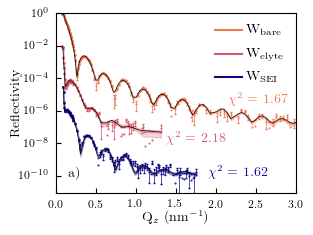

In [11]:
fig2 = plt.figure()
# set the dimensions and positions of the panels: left,bottom,width,height
fig2.set_size_inches([3.0,2.25])
ax2 = {"refl": fig2.add_axes([0.175,0.15,0.8,0.8])}#axis for z SLD profiles

# Initialize a 'scale' variable to offset the y-axis of the 3 data sets, for ease of viewing:
scale=[1.0,1./30000.,1./100.]
iplot=0
for m in models:
    #for n in modelArray[m]:
    for n,r in ReflData[m].items():
        # Get the data 'ready':
        Qz = Q[m][n].flatten()*10
        Qres_f = Qres[m][n].flatten()*10
        Rres_f = Rres[m][n].flatten()#*(Qz**4)
        ReflData_f = ReflData[m][n].flatten()
        
        ax2["refl"].semilogy(Q[m][n]*10, scale[iplot]*ReflData[m][n],marker='.',color=colors[iplot], markersize=1,linestyle='none')#, hold=True) # data
        
        ax2["refl"].errorbar(Qz, scale[iplot]*ReflData_f,yerr=scale[iplot]*Rres_f,capsize=1,elinewidth=0.5,ecolor=colors[iplot],fmt='none')

        # Plot the best
        ReflSim_0 = scale[iplot]*ReflSim[m][n][:,0]
        ax2["refl"].semilogy(Qz,ReflSim_0.T,'-k',linewidth=0.5,zorder=100)#,hold=True # best

        plot_quantiles(ax2["refl"],Qz, scale[iplot]*ReflSim[m][n].T, contours, colors[iplot],0.25)

        iplot += 1
           
        """if iplot:
            ax2["refl"].semilogy(Q[m]*10, scale[iplot]*ReflData[m],marker='.',color=colors[iplot], markersize=1,linestyle='none')#, hold=True) # data
            
            ax2["refl"].errorbar(Qz, scale[iplot]*ReflData_f,yerr=scale[iplot]*Rres_f,capsize=1,elinewidth=0.5,ecolor=colors[iplot],fmt='none')

            # Plot the best
            ReflSim_0 = scale[iplot]*ReflSim[m][:,0]
            ax2["refl"].semilogy(Qz,ReflSim_0.T,'-k',linewidth=0.5,zorder=100)#,hold=True # best
            
            plot_quantiles(ax2["refl"],Qz, scale[iplot]*ReflSim[m].T, contours, colors[iplot],0.25)

            iplot += 1
    
        else:
            ax2["refl"].semilogy(Q[m]*10, scale[iplot]*ReflData[m],marker='.',color=colors[iplot], markersize=1,linestyle='none')#, hold=True) # data
            
            ax2["refl"].errorbar(Qz, scale[iplot]*ReflData_f,yerr=scale[iplot]*Rres_f,capsize=1,elinewidth=0.5,ecolor=colors[iplot],fmt='none')
            
            # Plot the best
            ReflSim_0 = scale[iplot]*ReflSim[m][:,0]
            ax2["refl"].semilogy(Qz,ReflSim_0.T,'-k',linewidth=0.5,zorder=100)#,hold=True # best
                    
            plot_quantiles(ax2["refl"],Qz, scale[iplot]*ReflSim[m].T, contours, colors[iplot],0.25)

            iplot += 1"""

# Set the axis limits:
plt.xlim([0.0,3.0])
plt.ylim([0.9*10**(-11),1.1])
            
# Print the chi2 values for each fit:    
ax2["refl"].text(2.15,10**(-5.5),r"$\chi$" + "$^{2}$" + " = 1.67",fontsize=10,family='Times New Roman',color=colors[0])
ax2["refl"].text(1.375,10**(-7.9),r"$\chi$" + "$^{2}$" + " = 2.18",fontsize=10,family='Times New Roman',color=colors[2])
ax2["refl"].text(1.9,10**(-10.),r"$\chi$" + "$^{2}$" + " = 1.62",fontsize=10,family='Times New Roman',color=colors[1])
            
ax2["refl"].text(0.15,10**(-10.05),'a)',fontsize=10,family='Times New Roman')
    
# Set the tick parameters and values:
ax2['refl'].get_yaxis().set_tick_params('both', direction='in',pad=5.0)
ax2['refl'].get_xaxis().set_tick_params('both', direction='in',pad=5.0)
plt.yticks([10**(-10),10**(-8),10**(-6),10**(-4),10**(-2),10**(0)])
plt.xticks([0,0.5,1.0,1.5,2.0,2.5,3.0])

for tick in ax2['refl'].xaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
for tick in ax2['refl'].yaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
    
    
# Label the x and y axes:
ax2["refl"].set_xlabel('Q' + "$_z$" + ' (nm'+"$^{-1}$"+')',fontname='Times New Roman',fontsize=10,labelpad=0.5)
ax2["refl"].set_ylabel('Reflectivity',fontname='Times New Roman',fontsize=10,labelpad=-2.5)

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Create the legend.  Again, to avoid error bars and other artifacts, create three 'dummy' plots to represent
#    each data set:
plots = list()
plots.append(plt.matplotlib.lines.Line2D([0, 1],[0,1],linewidth=1.5,color=colors[0]))
plots.append(plt.matplotlib.lines.Line2D([0, 1],[0,1],linewidth=1.5,color=colors[2]))
plots.append(plt.matplotlib.lines.Line2D([0, 1],[0,1],linewidth=1.5,color=colors[1]))
font = plt.matplotlib.font_manager.FontProperties(family='Times New Roman',size=10)
plt.legend(plots,[ 'W'+r'$_{\mathrm{bare}}$','W'+r'$_{\mathrm{elyte}}$', 'W'+r"$_{\mathrm{SEI}}$"],
           prop=font,borderaxespad = 0.5, loc=1,labelspacing = 0.75,handletextpad = 0.25,frameon=False)
    
# Save the figure:
plt.savefig('NR_Data.png',dpi=350)

# Inspect the figure, here:
plt.show()